In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.gridspec import GridSpec

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory
output_dir = Path("../data/results/new_charts")
output_dir.mkdir(parents=True, exist_ok=True)

print("Setup complete!")

Setup complete!


In [11]:
# Load combined results
data_path = Path("../data/output/combined_results.json")
with open(data_path, 'r') as f:
    results = json.load(f)

print(f"Loaded {len(results)} models")
print("Models:", [r['model_name'] for r in results])

Loaded 12 models
Models: ['Xception', 'InceptionV4', 'ConvNeXt_Base', 'AlexNet', 'VGG16', 'resnet50', 'densenet121', 'mobilenet_v2', 'shufflenet_v2', 'squeezenet1_0', 'mnasnet1_0', 'tf_efficientnet_lite4']


In [12]:
# Define model clusters
clusters = {
    'Classical Models': ['AlexNet', 'VGG16'],
    'Lightweight Models': ['SqueezeNet', 'MobileNet', 'ShuffleNet', 'MnasNet1', 'EfficientNet'],
    'Modern Architecture': ['ResNet50', 'InceptionV4', 'Xception', 'DenseNet121', 'ConvNeXt']
}

# Create a mapping from model names in results to clusters
def find_cluster(model_name):
    model_lower = model_name.lower()
    for cluster_name, cluster_models in clusters.items():
        for cluster_model in cluster_models:
            if cluster_model.lower() in model_lower:
                return cluster_name
    return 'Unknown'

# Add cluster information to each result
for result in results:
    result['cluster'] = find_cluster(result['model_name'])

# Display cluster assignments
print("\nCluster Assignments:")
for result in results:
    print(f"{result['model_name']}: {result['cluster']}")


Cluster Assignments:
Xception: Modern Architecture
InceptionV4: Modern Architecture
ConvNeXt_Base: Modern Architecture
AlexNet: Classical Models
VGG16: Classical Models
resnet50: Modern Architecture
densenet121: Modern Architecture
mobilenet_v2: Lightweight Models
shufflenet_v2: Lightweight Models
squeezenet1_0: Lightweight Models
mnasnet1_0: Lightweight Models
tf_efficientnet_lite4: Lightweight Models


## 1. ROC Curves (Combined View)

/var/folders/t5/f7h8xdc15fv4wlpvsmrs4j2r0000gn/T/ipykernel_18562/450571548.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


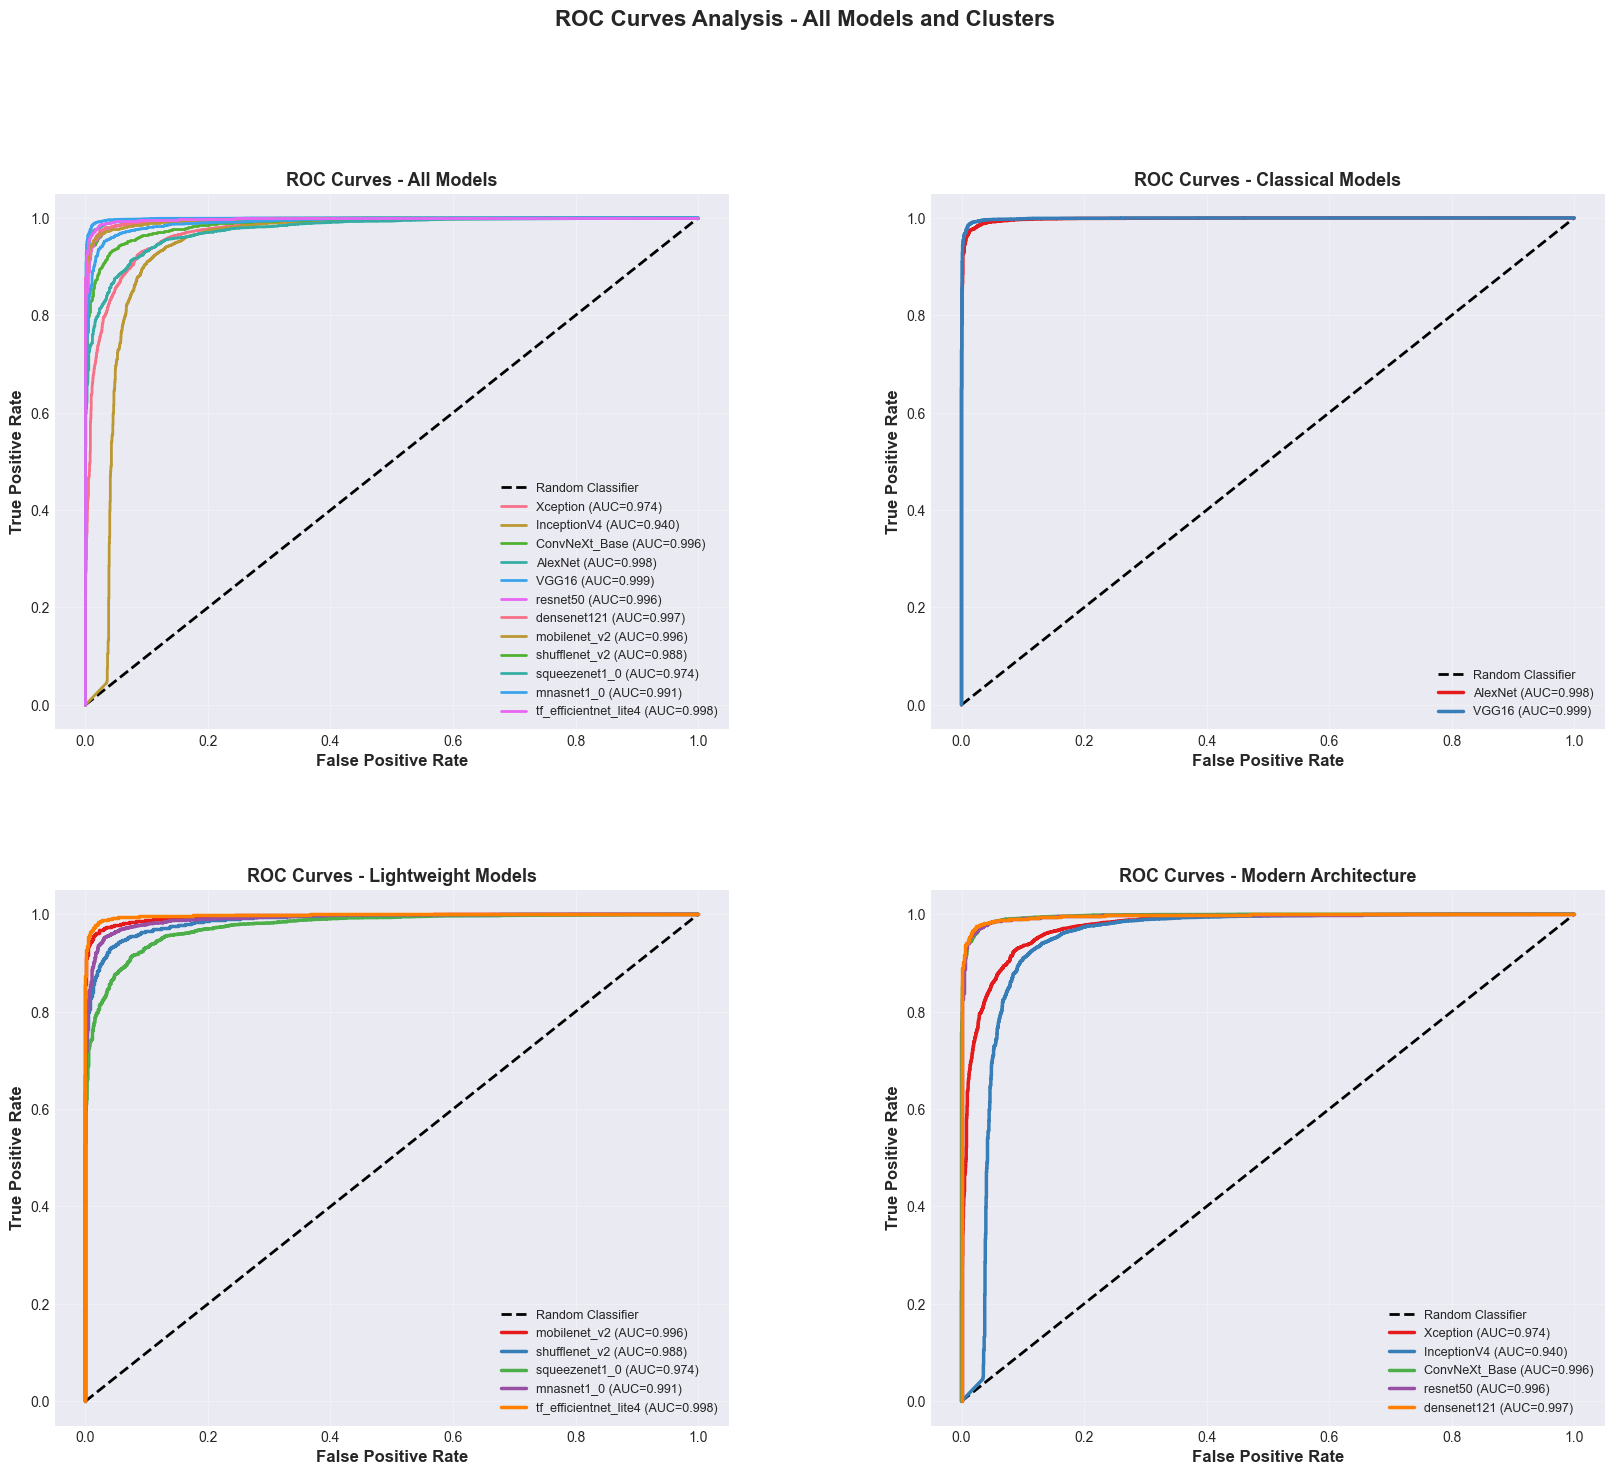

ROC curves saved!


In [13]:
# Create ROC curve visualization with 4 subplots
# Layout: Top-left (All models), Top-right (Classical), Bottom-left (Lightweight), Bottom-right (Modern)
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

cluster_names = ['Classical Models', 'Lightweight Models', 'Modern Architecture']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
subplot_configs = [
    {'title': 'All Models', 'cluster': None, 'position': (0, 0)},
    {'title': 'Classical Models', 'cluster': 'Classical Models', 'position': (0, 1)},
    {'title': 'Lightweight Models', 'cluster': 'Lightweight Models', 'position': (1, 0)},
    {'title': 'Modern Architecture', 'cluster': 'Modern Architecture', 'position': (1, 1)}
]

colors_per_cluster = [plt.cm.Set1(i) for i in range(10)]

for config in subplot_configs:
    ax = fig.add_subplot(gs[config['position'][0], config['position'][1]])
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    color_idx = 0
    
    if config['cluster'] is None:
        # All models subplot
        for result in results:
            if result.get('roc_fpr') and result.get('roc_tpr'):
                fpr = result['roc_fpr']
                tpr = result['roc_tpr']
                auc = result.get('auc_roc', 0)
                ax.plot(fpr, tpr, lw=2, label=f"{result['model_name']} (AUC={auc:.3f})")
    else:
        # Cluster-specific subplot
        for result in results:
            if result['cluster'] == config['cluster'] and result.get('roc_fpr') and result.get('roc_tpr'):
                fpr = result['roc_fpr']
                tpr = result['roc_tpr']
                auc = result.get('auc_roc', 0)
                ax.plot(fpr, tpr, lw=2.5, color=colors_per_cluster[color_idx], 
                       label=f"{result['model_name']} (AUC={auc:.3f})")
                color_idx += 1
    
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title(f'ROC Curves - {config["title"]}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('ROC Curves Analysis - All Models and Clusters', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir / 'roc_curves_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves saved!")

## 2. Training vs Validation Loss

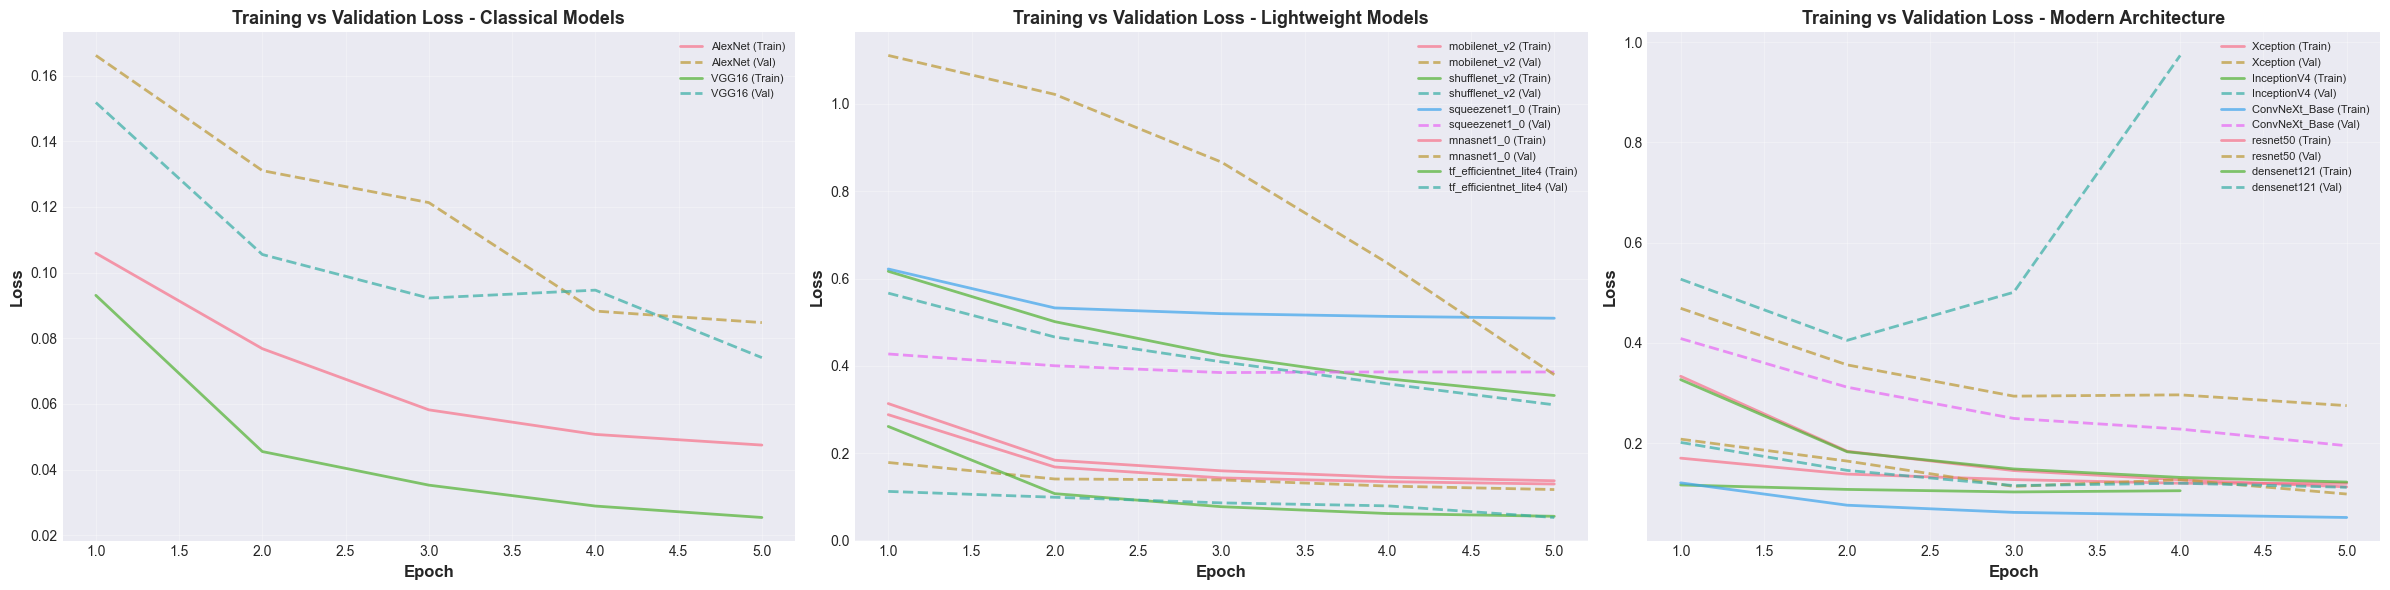

Training vs Validation Loss plots saved!


In [14]:
# Create Training vs Validation Loss plots for each cluster
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for idx, cluster_name in enumerate(cluster_names):
    ax = axes[idx]
    
    for result in results:
        if result['cluster'] == cluster_name:
            train_losses = result.get('train_losses', [])
            val_losses = result.get('val_losses', [])
            
            if train_losses and val_losses:
                epochs = range(1, len(train_losses) + 1)
                ax.plot(epochs, train_losses, '-', linewidth=2, alpha=0.7, 
                       label=f"{result['model_name']} (Train)")
                ax.plot(epochs, val_losses, '--', linewidth=2, alpha=0.7,
                       label=f"{result['model_name']} (Val)")
    
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title(f'Training vs Validation Loss - {cluster_name}', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'train_val_loss_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training vs Validation Loss plots saved!")

## 3. Performance Metrics Clustered Bar Chart

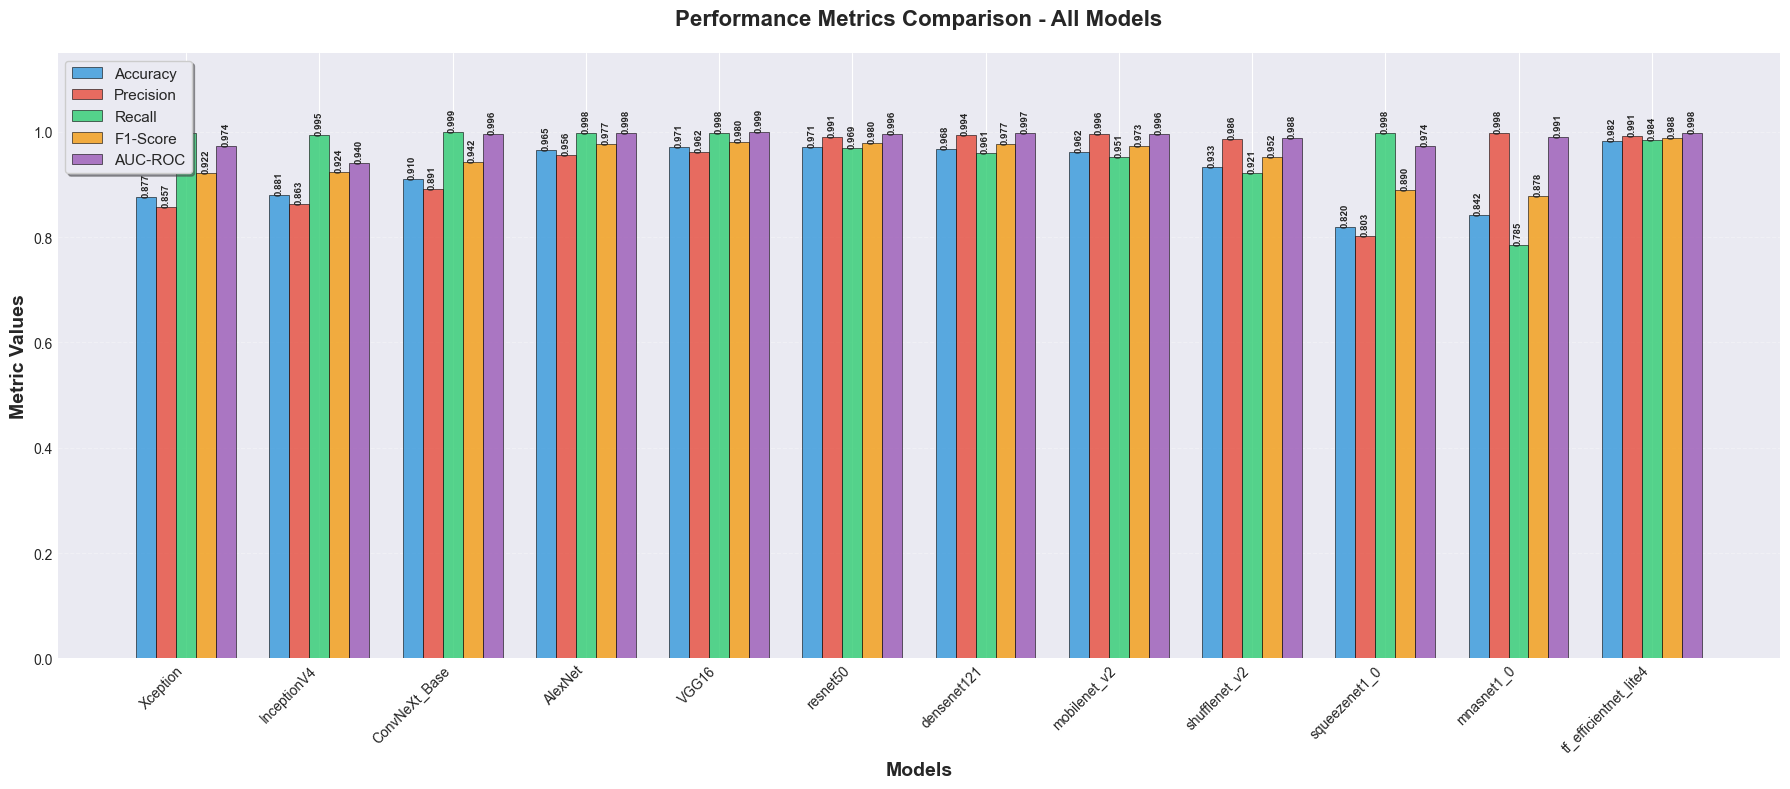


Metrics bar chart saved!
Metrics data saved to ../data/results/new_charts/performance_metrics_table.csv


In [19]:
# Create performance metrics data
metrics_data = []

for result in results:
    metrics_data.append({
        'Model': result['model_name'],
        'Cluster': result['cluster'],
        'Accuracy': result.get('accuracy', 0),
        'Precision': result.get('precision', 0),
        'Recall': result.get('recall', 0),
        'F1-Score': result.get('f1_score', 0),
        'AUC-ROC': result.get('auc_roc', 0)
    })

df_metrics = pd.DataFrame(metrics_data)

# Save as CSV
df_metrics.to_csv(output_dir / 'performance_metrics_table.csv', index=False)

# Create clustered bar chart
fig, ax = plt.subplots(figsize=(18, 8))

# Prepare data for plotting
models = df_metrics['Model'].tolist()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(models))
width = 0.15  # Width of each bar

# Define colors for each metric
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Create bars for each metric
for i, (metric, color) in enumerate(zip(metrics, colors)):
    values = df_metrics[metric].tolist()
    offset = width * (i - 2)  # Center the bars around x position
    bars = ax.bar(x + offset, values, width, label=metric, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=7, rotation=90, fontweight='bold')

# Customize the plot
ax.set_xlabel('Models', fontsize=14, fontweight='bold')
ax.set_ylabel('Metric Values', fontsize=14, fontweight='bold')
ax.set_title('Performance Metrics Comparison - All Models', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
ax.set_ylim(0, 1.15)  # Set y-axis limit to accommodate labels
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig(output_dir / 'performance_metrics_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMetrics bar chart saved!")
print(f"Metrics data saved to {output_dir / 'performance_metrics_table.csv'}")

## 4. Confusion Matrices

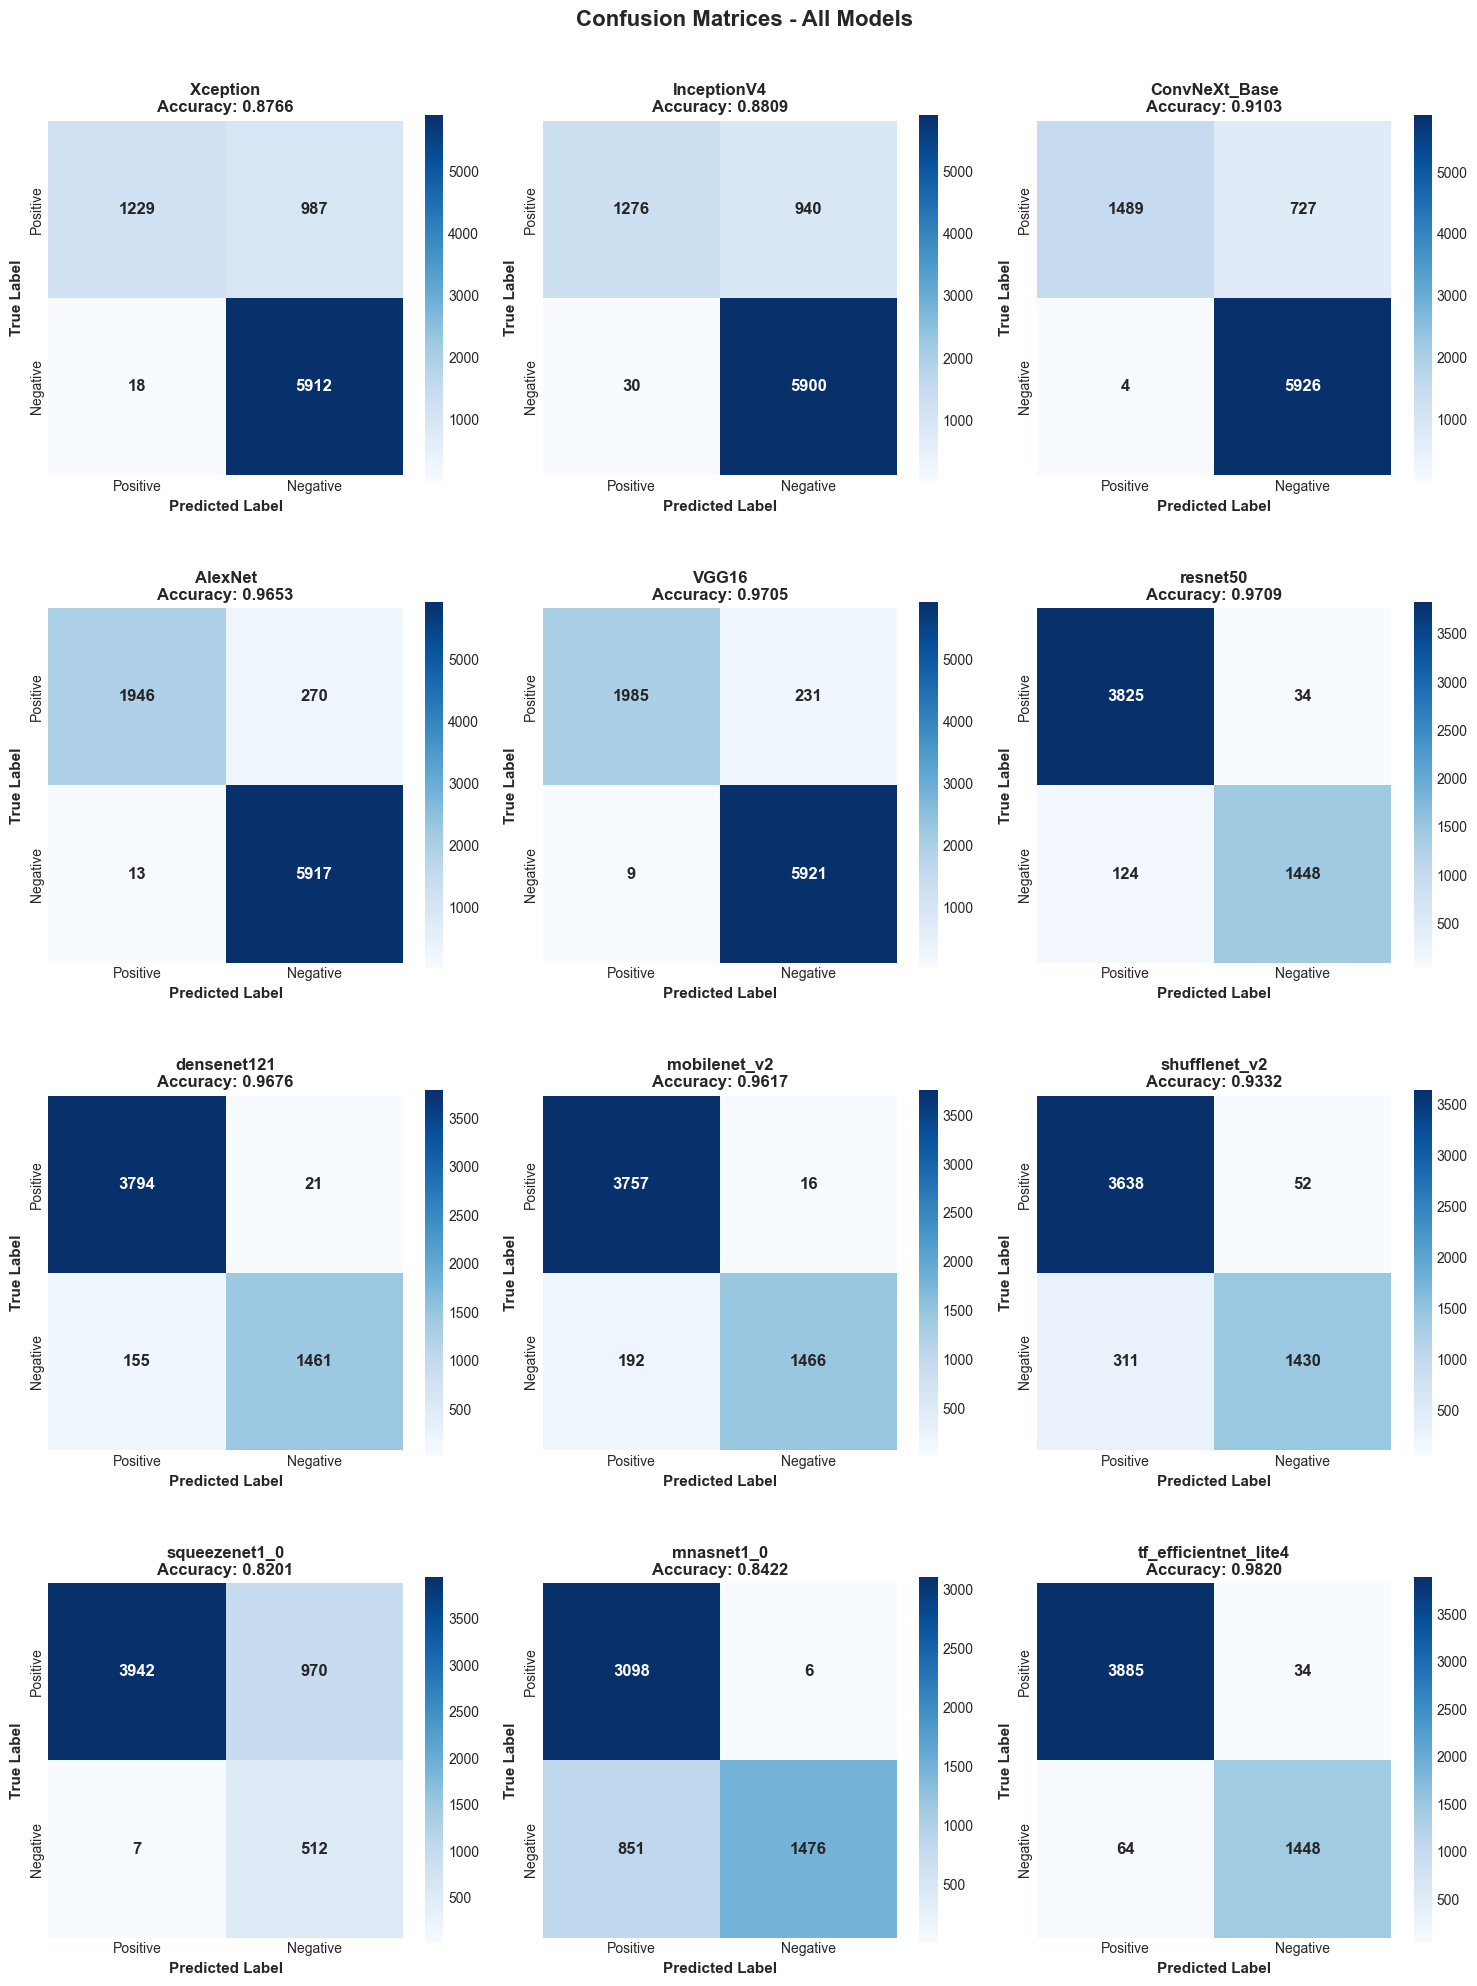

Confusion matrices saved!


In [16]:
# Create confusion matrices for all models
n_models = len(results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, result in enumerate(results):
    ax = axes[idx]
    cm = np.array(result.get('confusion_matrix', [[0, 0], [0, 0]]))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                square=True, ax=ax, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 12, 'weight': 'bold'})
    
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_title(f"{result['model_name']}\nAccuracy: {result.get('accuracy', 0):.4f}", 
                fontsize=12, fontweight='bold')
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])

# Hide extra subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.savefig(output_dir / 'confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved!")

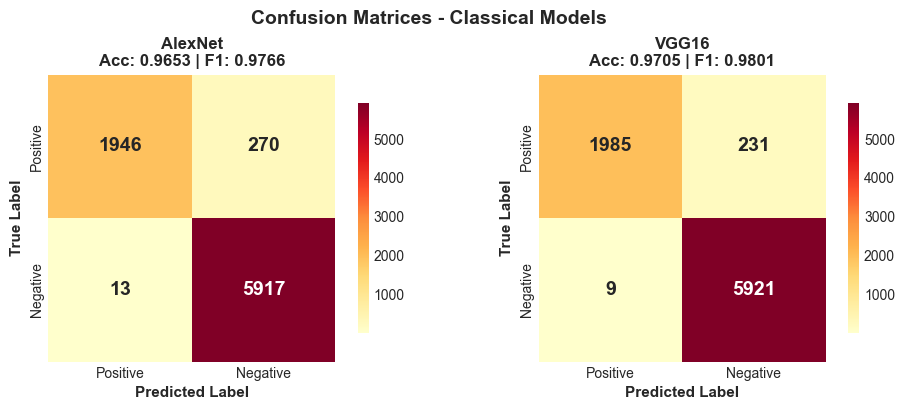

Confusion matrices for Classical Models saved!


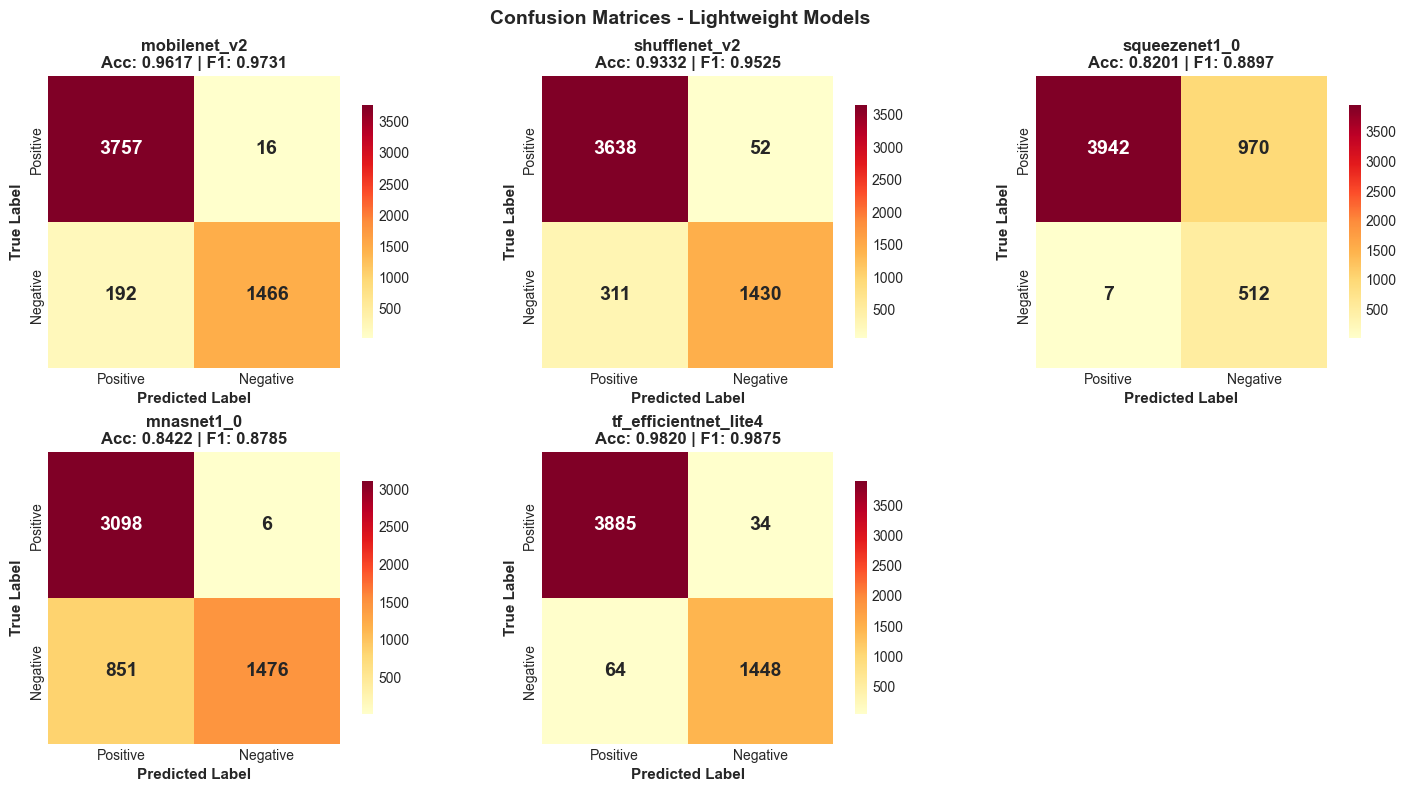

Confusion matrices for Lightweight Models saved!


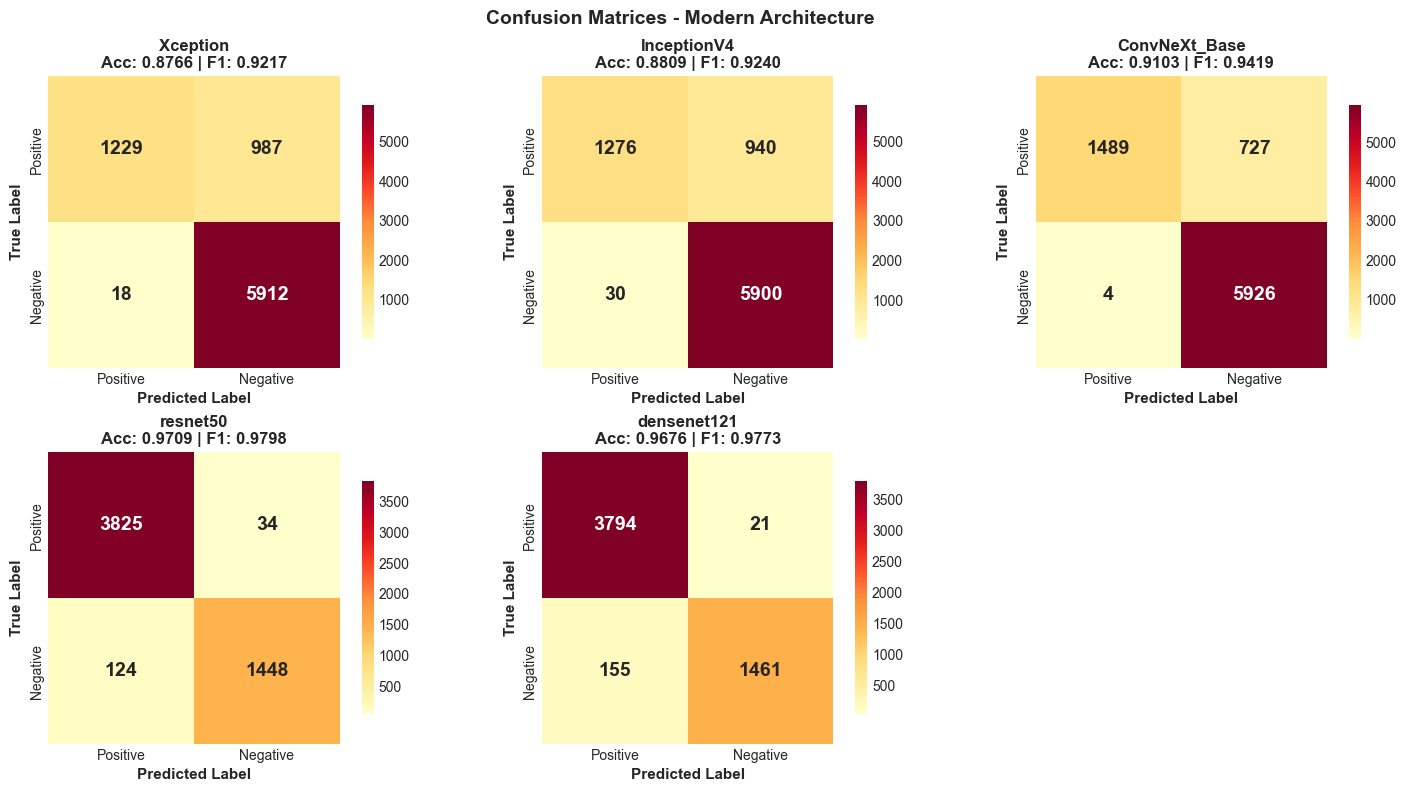

Confusion matrices for Modern Architecture saved!


In [17]:
# Create confusion matrices grouped by cluster
for cluster_name in cluster_names:
    cluster_results = [r for r in results if r['cluster'] == cluster_name]
    
    if not cluster_results:
        continue
    
    n_models = len(cluster_results)
    n_cols = min(3, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes
    
    for idx, result in enumerate(cluster_results):
        ax = axes[idx]
        cm = np.array(result.get('confusion_matrix', [[0, 0], [0, 0]]))
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
                    square=True, ax=ax, cbar_kws={'shrink': 0.8},
                    annot_kws={'size': 14, 'weight': 'bold'})
        
        ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
        ax.set_title(f"{result['model_name']}\nAcc: {result.get('accuracy', 0):.4f} | F1: {result.get('f1_score', 0):.4f}", 
                    fontsize=12, fontweight='bold')
        ax.set_xticklabels(['Positive', 'Negative'])
        ax.set_yticklabels(['Positive', 'Negative'])
    
    # Hide extra subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Confusion Matrices - {cluster_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save with filename based on cluster
    filename = f"confusion_matrices_{cluster_name.lower().replace(' ', '_')}.png"
    plt.savefig(output_dir / filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Confusion matrices for {cluster_name} saved!")

## Summary

In [ ]:
print("\n" + "="*60)
print("ALL VISUALIZATIONS COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nAll plots saved to: {output_dir.absolute()}")
print("\nGenerated files:")
print("  1. roc_curves_combined.png - ROC curves (4 subplots: All, Classical, Lightweight, Modern)")
print("  2. train_val_loss_by_cluster.png - Training vs Validation loss")
print("  3. performance_metrics_bar_chart.png - Clustered bar chart of all metrics")
print("  4. performance_metrics_table.csv - Metrics in CSV format")
print("  5. confusion_matrices_all_models.png - All confusion matrices")
print("  6. confusion_matrices_classical_models.png")
print("  7. confusion_matrices_lightweight_models.png")
print("  8. confusion_matrices_modern_architecture.png")
print("\n" + "="*60)


ALL VISUALIZATIONS COMPLETED SUCCESSFULLY!

All plots saved to: /Users/pratyaksh/UTA/sem3/CV/plantvillage-study/notebooks/../data/results/new_charts

Generated files:
  1. roc_curves_combined.png - ROC curves (4 subplots: All, Classical, Lightweight, Modern)
  2. train_val_loss_by_cluster.png - Training vs Validation loss
  3. performance_metrics_table.png - Performance metrics visualization
  4. performance_metrics_table.csv - Metrics in CSV format
  5. confusion_matrices_all_models.png - All confusion matrices
  6. confusion_matrices_classical_models.png
  7. confusion_matrices_lightweight_models.png
  8. confusion_matrices_modern_architecture.png



# PlantDoc Dataset Results

Generate visualizations for PlantDoc test results.

In [20]:
# Load PlantDoc combined results
plantdoc_data_path = Path("../data/output/plantdoc_test_results_combined.json")
with open(plantdoc_data_path, 'r') as f:
    plantdoc_results = json.load(f)

print(f"Loaded {len(plantdoc_results)} models from PlantDoc")
print("Models:", [r['model_name'] for r in plantdoc_results])

# Add cluster information to each result
for result in plantdoc_results:
    result['cluster'] = find_cluster(result['model_name'])

# Display cluster assignments
print("\nCluster Assignments:")
for result in plantdoc_results:
    print(f"{result['model_name']}: {result['cluster']}")

Loaded 12 models from PlantDoc
Models: ['AlexNet', 'ConvNeXt', 'InceptionV4', 'VGG16', 'Xception', 'densenet121', 'mnasnet1_0', 'mobilenet_v2', 'resnet50', 'shufflenet_v2', 'squeezenet1_0', 'tf_efficientnet_lite4']

Cluster Assignments:
AlexNet: Classical Models
ConvNeXt: Modern Architecture
InceptionV4: Modern Architecture
VGG16: Classical Models
Xception: Modern Architecture
densenet121: Modern Architecture
mnasnet1_0: Lightweight Models
mobilenet_v2: Lightweight Models
resnet50: Modern Architecture
shufflenet_v2: Lightweight Models
squeezenet1_0: Lightweight Models
tf_efficientnet_lite4: Lightweight Models


## PlantDoc ROC Curves

/var/folders/t5/f7h8xdc15fv4wlpvsmrs4j2r0000gn/T/ipykernel_18562/2968592103.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


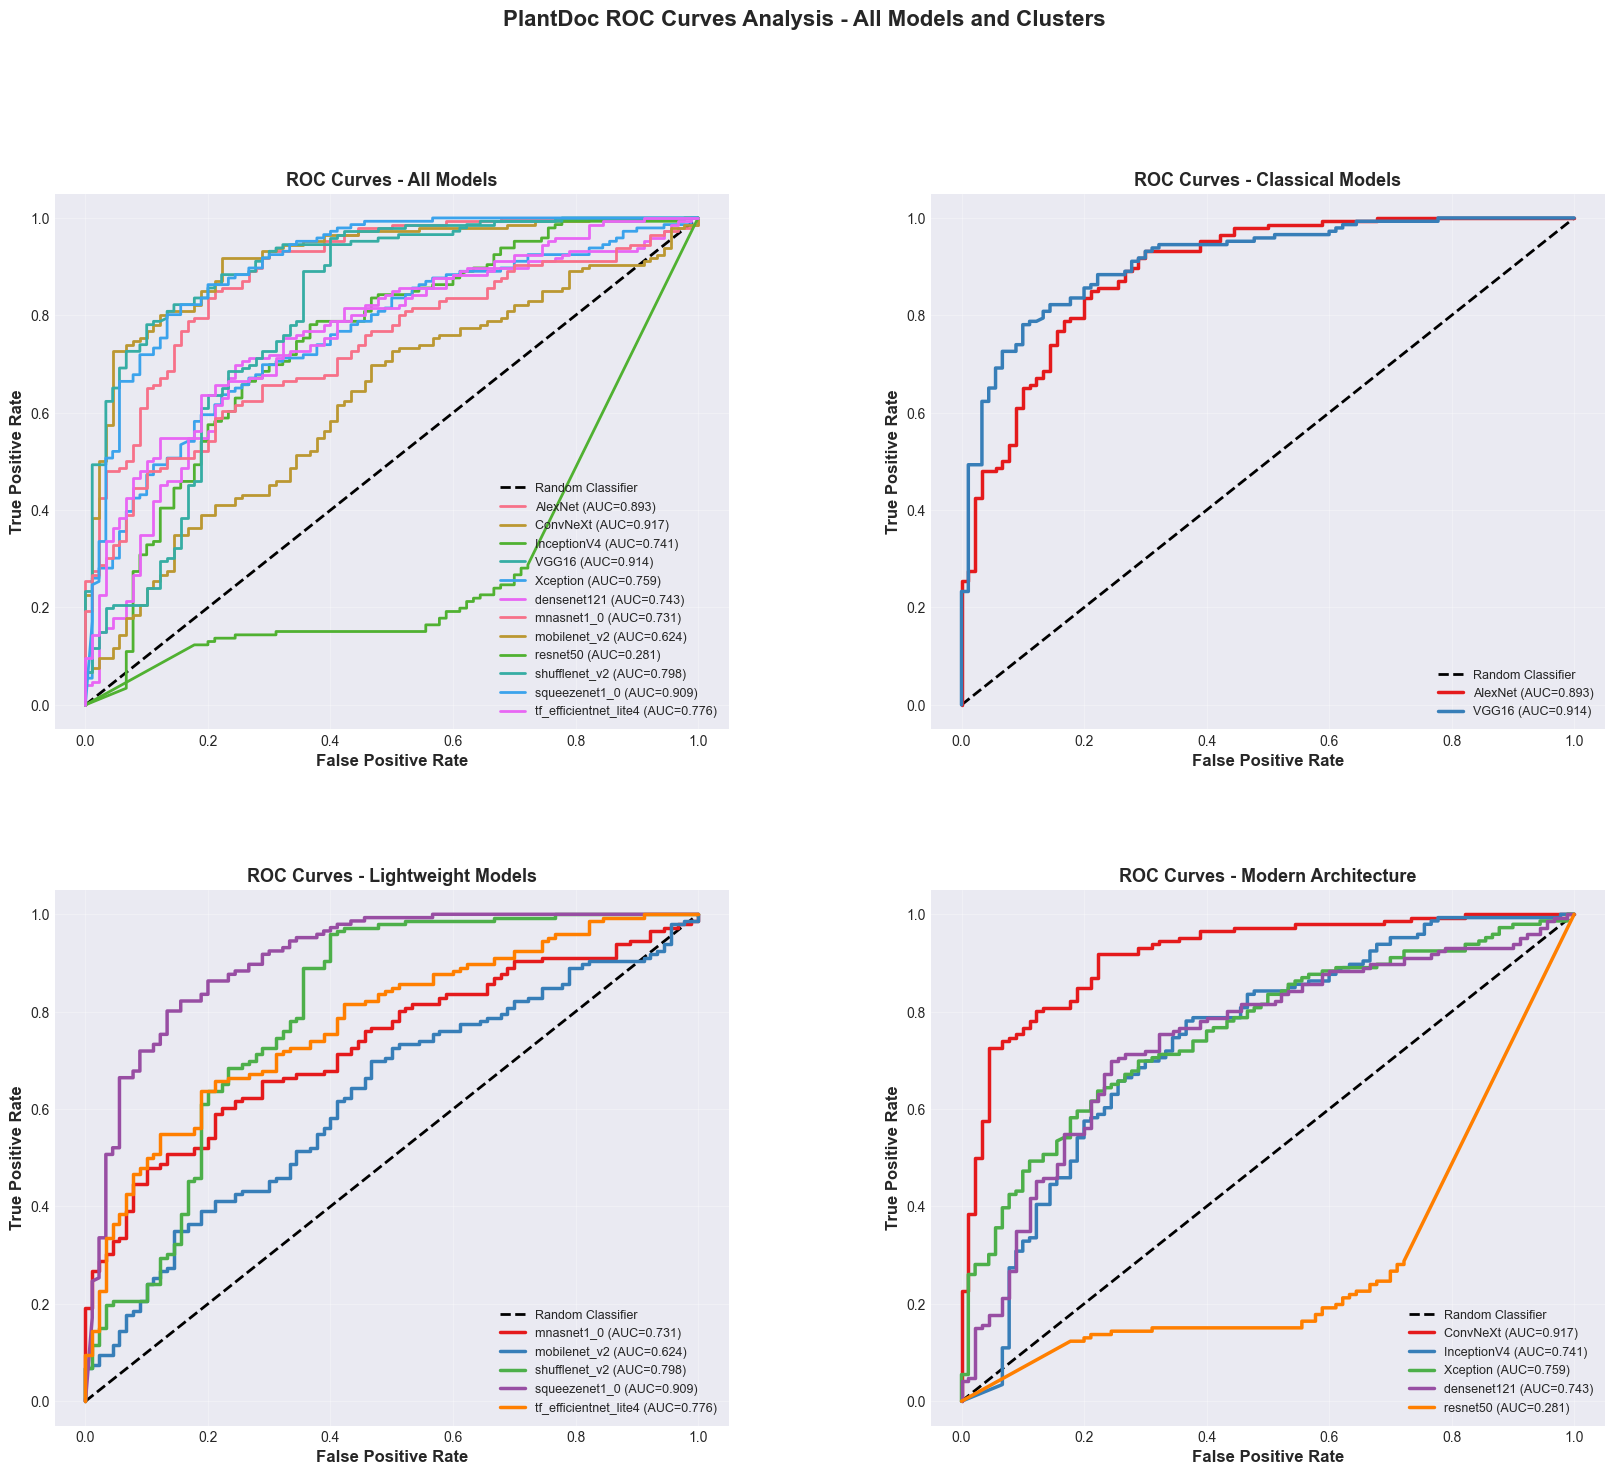

PlantDoc ROC curves saved!


In [21]:
# Create PlantDoc ROC curve visualization with 4 subplots
# Layout: Top-left (All models), Top-right (Classical), Bottom-left (Lightweight), Bottom-right (Modern)
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

subplot_configs = [
    {'title': 'All Models', 'cluster': None, 'position': (0, 0)},
    {'title': 'Classical Models', 'cluster': 'Classical Models', 'position': (0, 1)},
    {'title': 'Lightweight Models', 'cluster': 'Lightweight Models', 'position': (1, 0)},
    {'title': 'Modern Architecture', 'cluster': 'Modern Architecture', 'position': (1, 1)}
]

colors_per_cluster = [plt.cm.Set1(i) for i in range(10)]

for config in subplot_configs:
    ax = fig.add_subplot(gs[config['position'][0], config['position'][1]])
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    color_idx = 0
    
    if config['cluster'] is None:
        # All models subplot
        for result in plantdoc_results:
            if result.get('roc_fpr') and result.get('roc_tpr'):
                fpr = result['roc_fpr']
                tpr = result['roc_tpr']
                auc = result.get('auc_roc', 0)
                ax.plot(fpr, tpr, lw=2, label=f"{result['model_name']} (AUC={auc:.3f})")
    else:
        # Cluster-specific subplot
        for result in plantdoc_results:
            if result['cluster'] == config['cluster'] and result.get('roc_fpr') and result.get('roc_tpr'):
                fpr = result['roc_fpr']
                tpr = result['roc_tpr']
                auc = result.get('auc_roc', 0)
                ax.plot(fpr, tpr, lw=2.5, color=colors_per_cluster[color_idx], 
                       label=f"{result['model_name']} (AUC={auc:.3f})")
                color_idx += 1
    
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title(f'ROC Curves - {config["title"]}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('PlantDoc ROC Curves Analysis - All Models and Clusters', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir / 'plantdoc_roc_curves_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print("PlantDoc ROC curves saved!")

## PlantDoc Performance Metrics Bar Chart

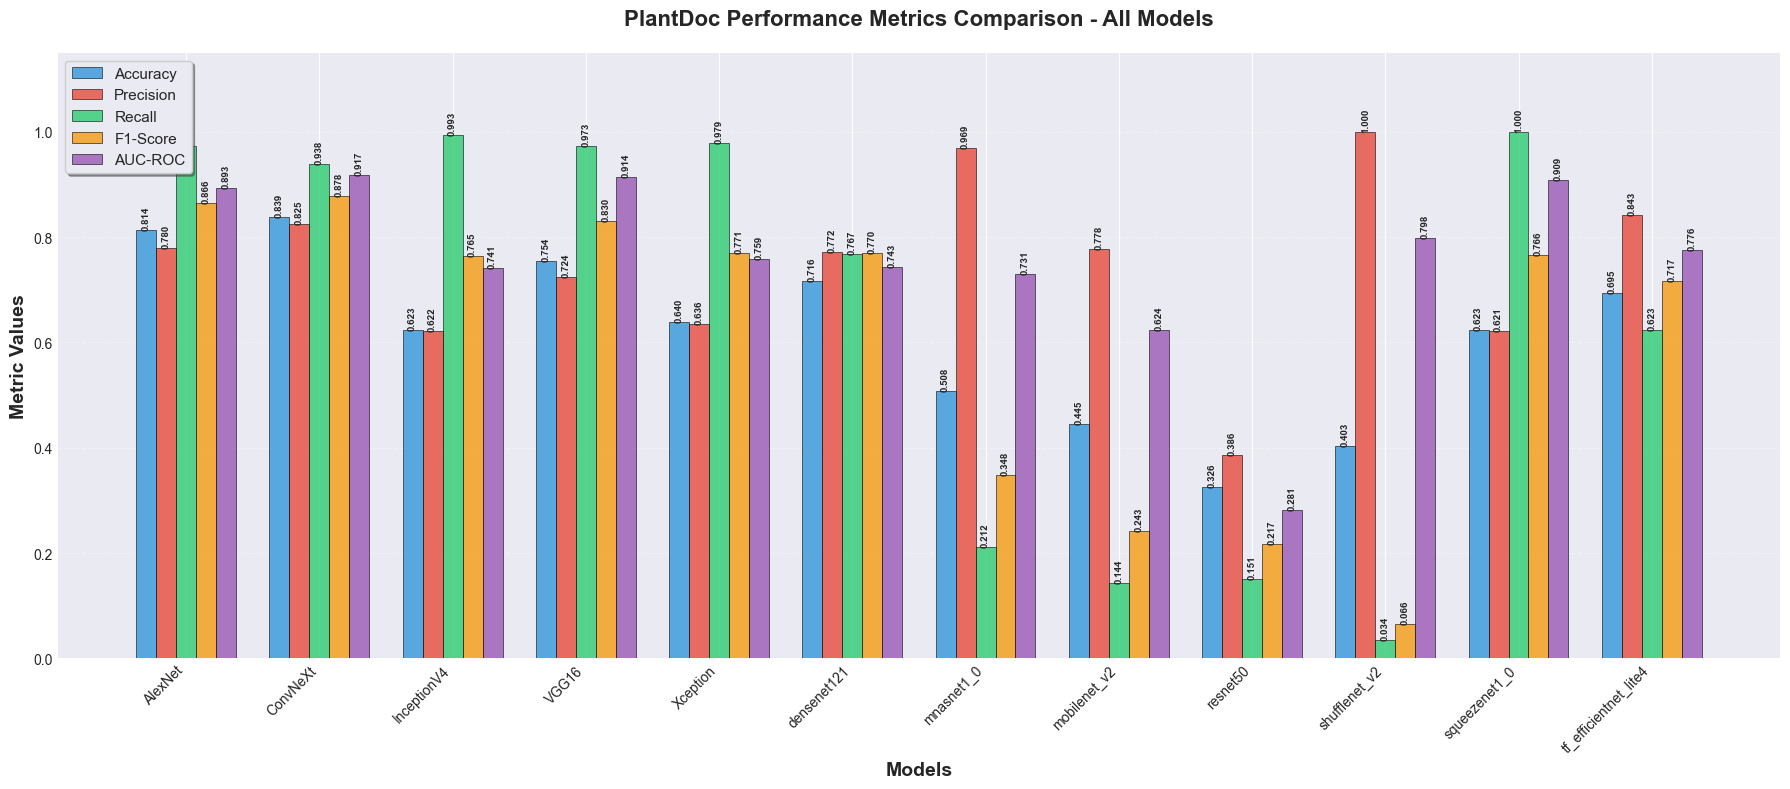


PlantDoc metrics bar chart saved!
PlantDoc metrics data saved to ../data/results/new_charts/plantdoc_performance_metrics_table.csv


In [22]:
# Create PlantDoc performance metrics data
plantdoc_metrics_data = []

for result in plantdoc_results:
    plantdoc_metrics_data.append({
        'Model': result['model_name'],
        'Cluster': result['cluster'],
        'Accuracy': result.get('accuracy', 0),
        'Precision': result.get('precision', 0),
        'Recall': result.get('recall', 0),
        'F1-Score': result.get('f1_score', 0),
        'AUC-ROC': result.get('auc_roc', 0)
    })

plantdoc_df_metrics = pd.DataFrame(plantdoc_metrics_data)

# Save as CSV
plantdoc_df_metrics.to_csv(output_dir / 'plantdoc_performance_metrics_table.csv', index=False)

# Create clustered bar chart
fig, ax = plt.subplots(figsize=(18, 8))

# Prepare data for plotting
plantdoc_models = plantdoc_df_metrics['Model'].tolist()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(plantdoc_models))
width = 0.15  # Width of each bar

# Define colors for each metric
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Create bars for each metric
for i, (metric, color) in enumerate(zip(metrics, colors)):
    values = plantdoc_df_metrics[metric].tolist()
    offset = width * (i - 2)  # Center the bars around x position
    bars = ax.bar(x + offset, values, width, label=metric, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=7, rotation=90, fontweight='bold')

# Customize the plot
ax.set_xlabel('Models', fontsize=14, fontweight='bold')
ax.set_ylabel('Metric Values', fontsize=14, fontweight='bold')
ax.set_title('PlantDoc Performance Metrics Comparison - All Models', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(plantdoc_models, rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
ax.set_ylim(0, 1.15)  # Set y-axis limit to accommodate labels
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig(output_dir / 'plantdoc_performance_metrics_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlantDoc metrics bar chart saved!")
print(f"PlantDoc metrics data saved to {output_dir / 'plantdoc_performance_metrics_table.csv'}")